In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 22.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=1cd3e77d3f945237f804efe1ad2738c7cb2c10eb68de5f28caede95fba95e85f
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=bc8d7949701fa7c389574f5f2daef046a2dfb2415c6e80c71b9d01ebe95804d6
  Stored in directory: /root/.cache/pip/w

In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nibabel as nib
import time
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.feature_extraction import create_feature_extractor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import segmentation_models_pytorch as smp

In [ ]:
torchvision.__version__


'0.15.1+cu118'

(240, 240, 155)


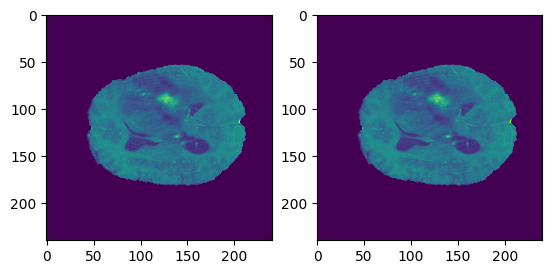

In [ ]:
img = nib.load('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii')
img_array = img.get_fdata()
print(img_array.shape)
plt.subplot(121)
plt.imshow(img_array[:,:,80])
plt.subplot(122)
plt.imshow(img_array[:,:,80])

(240, 240, 155)


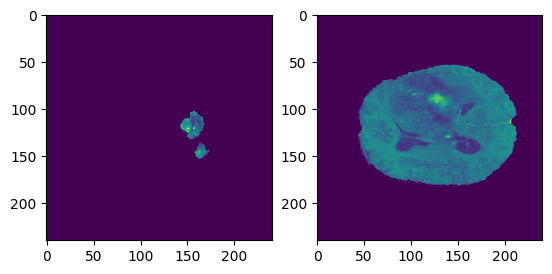

In [ ]:
mask = nib.load('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii')
mask_array = img.get_fdata()
print(mask_array.shape)
plt.subplot(121)
plt.imshow(mask_array[:,:,10])
plt.subplot(122)
plt.imshow(mask_array[:,:,80])

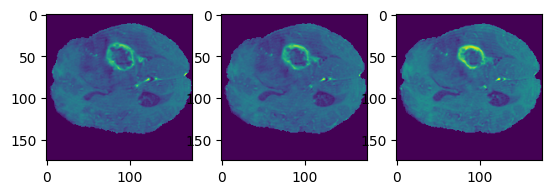

In [ ]:
i = 72
plt.subplot(131)
plt.imshow(img_array[40:215, 40:215, i])
plt.subplot(132)
plt.imshow(img_array[40:215, 40:215, i+1])
plt.subplot(133)
plt.imshow(img_array[40:215, 40:215, i+2])

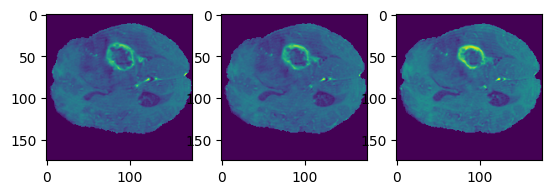

In [ ]:
i = 72
plt.subplot(131)
plt.imshow(mask_array[40:215, 40:215, i])
plt.subplot(132)
plt.imshow(mask_array[40:215, 40:215, i+1])
plt.subplot(133)
plt.imshow(mask_array[40:215, 40:215, i+2])

In [ ]:
x = img_array/np.max(img_array)
print(x.max())
print(type(x[0,0,0]))
x = x.astype(np.float32)
print(type(x[0,0,0]))

1.0
<class 'numpy.float64'>
<class 'numpy.float32'>


(240, 240, 155)
[0 1 2 4]


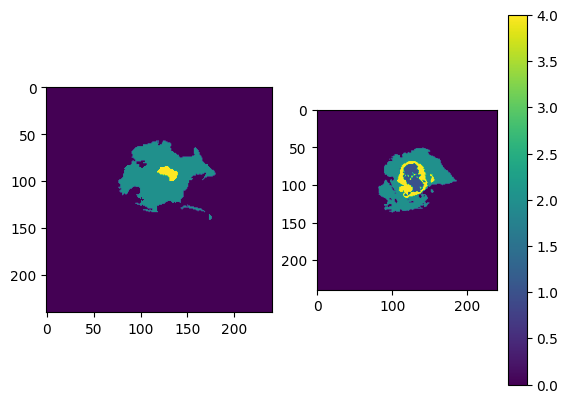

In [ ]:
mask = nib.load('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii')
mask_array = mask.get_fdata().astype(np.uint8)
print(mask_array.shape)
print(np.unique(mask_array))
plt.subplot(121)
plt.imshow(mask_array[:,:,80])
plt.subplot(122)
plt.imshow(mask_array[:,:,67])
plt.colorbar()

In [ ]:
print(np.unique(mask_array[:,:,0]))
print(np.unique(mask_array[:,:,67]))

[0]
[0 1 2 4]


In [ ]:
mask_array[mask_array == 4] = 3
np.unique(mask_array)

array([0, 1, 2, 3], dtype=uint8)

In [ ]:
black = []
good = []
for i in range(155):
    if np.unique(mask_array[:,:,i] == 0)[0] == True:
        black.append(i)
    else:
        good.append(i)
print(black)
print(good)
print(len(black), len(good))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]
72 83


In [ ]:
size = img_array[40:220, 40:220, 30:113].shape
size

(180, 180, 83)

In [ ]:
mask_array[:,:,0].shape

(240, 240)

In [ ]:
mask_array =  to_categorical(mask_array[:,:,0], num_classes=4)
mask_array = mask_array.astype(np.uint8)
mask_array.shape

(240, 240, 4)

In [ ]:
mask_array[1,0]

array([1, 0, 0, 0], dtype=uint8)

In [ ]:
train_images_paths = sorted(glob.glob('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
train_masks_paths = sorted(glob.glob('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
train_masks_paths.insert(354,'/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii')
scaler = MinMaxScaler()
print(len(train_images_paths))
print(len(train_masks_paths))

369
369


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_images_paths, train_masks_paths, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(len(x_train))
print(len(x_val))
print(len(x_test))


298
34
37


In [ ]:
def load_img(img_list):
    train_images= []
    for i, image_path in enumerate(img_list):
#         print(i)
        image_t1ce= nib.load(image_path).get_fdata()
        image_t1ce = image_t1ce/np.max(image_t1ce)
#         image_t1ce= scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)
        image_t1ce = image_t1ce.astype(np.float32)
#         temp_combined_images = temp_image_t1ce[...,np.newaxis]
#         print(temp_combined_images.shape)
#         image_t1ce= image_t1ce[40:220, 40:220, 30:113]
        image_t1ce= image_t1ce[:, :, 30:113]
        for j in range(83):
            channel = image_t1ce[:,:,j]
            RGB_img = np.repeat(channel[...,np.newaxis], 3, axis=-1)
#             print("RGB: ", RGB_img.shape)
            train_images.append(RGB_img)

    train_images = np.array(train_images)
    return train_images

def load_mask( mask_list):
    train_masks = []
    for i, mask_path in enumerate(mask_list):

        mask = nib.load(mask_path).get_fdata()
        mask[mask==4] = 3  #Reassign mask values 4 to 3
#         mask = mask[40:220, 40:220, 30:113]
        mask = mask[:, :, 30:113]
#         temp_mask= to_categorical(temp_mask, num_classes=4)
        for j in range(83):
            channel = mask[:,:,j]
            channel =  to_categorical(channel, num_classes=4)
            channel = channel.astype(np.float32)
            train_masks.append(channel)
#             train_masks.append(channel[...,np.newaxis])

    train_masks = np.array(train_masks)
    return train_masks



def imageLoader( img_list,  mask_list,batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_list[batch_start:limit])
#             X_new=np.moveaxis(X,-1,1)
#             X_new= X
            Y = load_mask( mask_list[batch_start:limit])
#             Y_new=np.moveaxis(Y,-1,1)

            yield (X,Y)#a tuple with two numpy arrays with batch_size samples
#             yield (X_new,[ Y_new , X_new] )#a tuple with two numpy arrays with batch_size samples


            batch_start += batch_size
            batch_end += batch_size

In [ ]:
cc = load_mask(train_masks_paths[:10])
cc.shape

(830, 240, 240, 4)

In [ ]:
np.unique(cc[1])

array([0., 1.], dtype=float32)

In [ ]:
batch_size = 1
IMAGE_SIZE = 240
NUM_CLASSES = 4

In [ ]:
train_datagen = imageLoader(x_train, y_train, batch_size)
# val_datagen = imageLoader(x_test, y_test, batch_size)

In [ ]:
def convolution_block(block_input,num_filters=128, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def AtrousSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)
    print("Inside dspp, out_pool: ", out_pool.shape)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_shape = (240,240,3))
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 120, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model

def DeepLabv3(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    input_tensor = Input(shape=input_shape)
    x = base_model(input_tensor)
    dilations = [6, 12, 18]
    aspp_layers = []
    for dilation_rate in dilations:
        aspp_layer = Conv2D(filters=256, kernel_size=1, activation='relu')(x)
        aspp_layer = Conv2D(filters=256, kernel_size=3, dilation_rate=dilation_rate, padding='same', activation='relu')(aspp_layer)
        aspp_layers.append(aspp_layer)
    merged = tf.concat(aspp_layers, axis=-1)
    x = Conv2D(filters=256, kernel_size=1, activation='relu')(merged)
    x = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    mask = Conv2D(filters=num_classes, kernel_size=1, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=mask)

    return model

In [ ]:
model = DeeplabV3(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
# model.summary()

dspp in:  (None, 15, 15, 256)
Inside dspp, out_pool:  (None, 15, 15, 128)
dspp out:  (None, 15, 15, 128)
4
encoder out:  (None, 60, 60, 128)
first out:  (None, 60, 60, 24)


In [ ]:
checkpoint_filepath = '/kaggle/working/checkpoint/'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_best_only = True
    )

In [ ]:
def dice_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    return 1 - dice

In [ ]:
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=dice_coeff,
)

In [ ]:
#model.load_weights('/content/drive/MyDrive/Dataset_BraTS/brats_3d_deeplabv3.hdf5')

In [ ]:
history = model.fit(train_datagen, epochs=5, steps_per_epoch=10, callbacks=[checkpoint])


Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.3191 - dice_coeff: 0.6809 

10/10 [==============================] - 546s 54s/step - loss: 0.3191 - dice_coeff: 0.6809
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.1267 - dice_coeff: 0.8733 

10/10 [==============================] - 528s 53s/step - loss: 0.1267 - dice_coeff: 0.8733
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.0657 - dice_coeff: 0.9343 

10/10 [==============================] - 538s 54s/step - loss: 0.0657 - dice_coeff: 0.9343
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 0.0565 - dice_coeff: 0.9435 

10/10 [==============================] - 533s 54s/step - loss: 0.0565 - dice_coeff: 0.9435
Epoch 5/5
10/10 [==============================] - ETA: 0s - loss: 0.0424 - dice_coeff: 0.9576 

10/10 [==============================] - 531s 53s/step - loss: 0.0424 - dice_coeff: 0.9576


In [ ]:
model.save_weights('/content/drive/MyDrive/Dataset_BraTS/brats_3d_deeplabv3.hdf5')

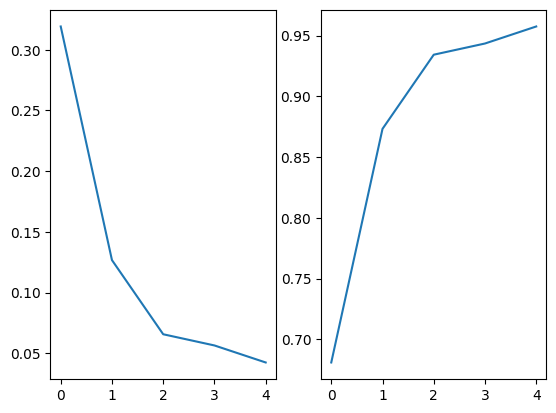

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(history.history['loss'])
# ax1.plot(model_history.history['val_loss'])
# ax1.legend(['Training loss', 'val_loss'])

# ax2.plot(model_history.history['val_dice_coeff'])
ax2.plot(history.history['dice_coeff'])
# ax2.legend(['val_dice_coeff', 'dice_coeff'])


In [ ]:
len(x_train)

298

In [ ]:
test_image = nib.load(x_train[0]).get_fdata()
test_image = test_image/np.max(test_image)
test_image = test_image.astype(np.float32)
test_image_slice = np.repeat(test_image[:,:,100][...,np.newaxis], 3, axis=-1)
test_image_slice = test_image_slice[np.newaxis,...]

mask = nib.load(y_train[0]).get_fdata()
mask[mask==4] = 10  #Reassign mask values 4 to 3
# mask =  to_categorical(mask[:,:,72], num_classes=4)
# mask = mask.astype(np.float32)
print(mask.shape)

pred = model.predict(test_image_slice)[0]
pred.shape

(240, 240, 155)
1/1 [==============================] - 0s 320ms/step


(240, 240, 4)

In [ ]:
# predictions = np.squeeze(pred)
predictions = np.argmax(pred, axis=2)
predictions.shape

(240, 240)

In [ ]:
np.unique(predictions)

array([0, 1, 2, 3])

Text(0.5, 1.0, 'Predicted')

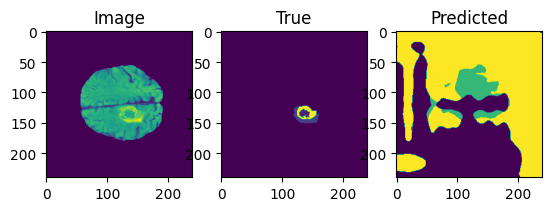

In [ ]:
plt.subplot(131)
plt.imshow(test_image[:,:,100])
plt.title('Image')
plt.subplot(132)
plt.imshow(mask[:,:,100])
plt.title('True')
plt.subplot(133)
plt.imshow(predictions)
plt.title("Predicted")